In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Disease

/content/drive/MyDrive/Colab Notebooks/Disease


# Imports

In [3]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Preprocessing

In [4]:
df = pd.read_csv('train.csv')

# total 4 classes, leave only original data
df.loc[df['timestamp(day)'].isin([-5, -4]), 'timestamp(day)'] = -3
df= df[df['original'] == 1]
df.reset_index(drop=True, inplace=True)
print(df)
# df array of each patient
df_array = []

# one df by one patient, make and df_array
group_start_index = 0
for i, row in df.iterrows():
    if row['timestamp(hr)'] == 0 and row['timestamp(day)'] == 0:
        group_df = df[group_start_index:i+1].copy()
        df_array.append(group_df)
        group_start_index = i+1

#imputation: fill NaN values using mean value
for df_patient in df_array:
  df_patient.fillna(df_patient.mean(), inplace=True)

# Combine patient dataframes
df_combined = pd.concat(df_array)
df_combined.fillna(df_combined.mean(), inplace=True) # imputation with values still with NaN

          1     2     3      4      5     6     7     8    9  10  ...    28  \
0       0.0  62.0   NaN    NaN    NaN   NaN   NaN  0.02  0.3 NaN  ...  78.6   
1       0.0  62.0  63.0  106.0  106.0  19.0  37.0   NaN  NaN NaN  ...   NaN   
2       0.0  62.0  94.0  144.0    NaN   NaN   NaN   NaN  NaN NaN  ...   NaN   
3       0.0  62.0  88.0  113.0   94.0  15.0   NaN   NaN  NaN NaN  ...   NaN   
4       0.0  62.0  83.0   96.0   98.0  20.0  36.3   NaN  NaN NaN  ...   NaN   
...     ...   ...   ...    ...    ...   ...   ...   ...  ...  ..  ...   ...   
175509  1.0  69.0   NaN    NaN   49.0  20.0  36.2   NaN  NaN NaN  ...   NaN   
175510  1.0  69.0   NaN    NaN   50.0  20.0  36.4   NaN  NaN NaN  ...   NaN   
175511  1.0  69.0  74.0  173.0    NaN   NaN   NaN   NaN  NaN NaN  ...   NaN   
175512  1.0  69.0   NaN    NaN   47.0  20.0  36.7   NaN  NaN NaN  ...   NaN   
175513  1.0  69.0  67.0  155.0   46.0  22.0  36.4   NaN  NaN NaN  ...   NaN   

        29    30  31    32    33    34  timestamp(d

In [5]:
# features, labels
x = df_combined.drop('timestamp(day)', axis=1)
y = df_combined['timestamp(day)']

# Apply Minmax normalization
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x)
df_normalized= pd.DataFrame(x_normalized, columns=x.columns)
df_normalized['timestamp(day)'] = y

# Perform SMOTE to address data imbalance
labels = df_normalized['timestamp(day)']

smote = SMOTE()
df_resampled, labels_resampled = smote.fit_resample(df_normalized.drop('timestamp(day)', axis=1), labels)
df_resampled = pd.DataFrame(df_resampled, columns=df_normalized.drop('timestamp(day)', axis=1).columns)
df_resampled['timestamp(day)'] = labels_resampled

# Perform cross-validation using SVM
x = df_resampled.drop('timestamp(day)', axis=1)
y = df_resampled['timestamp(day)']
svm_classifier = SVC(kernel='linear', decision_function_shape='ovr')

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(svm_classifier, x, y, cv=cv)

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean Score:", scores.mean())

# Create a final dataframe
df= pd.DataFrame(x, columns=x.columns)
df['timestamp(day)'] = y
print(df.head())

Cross-Validation Scores: [0.99869224 0.99869224 0.99869224 0.99896964 0.99823651]
Mean Score: 0.9986565744630262
     1         2         3         4         5         6         7         8  \
0  0.0  0.531646  0.094526  0.013342  0.010483  0.099884  0.009769  0.004464   
1  0.0  0.531646  0.078554  0.013853  0.011625  0.094059  0.009896  0.003571   
2  0.0  0.531646  0.117207  0.018819  0.010483  0.099884  0.009769  0.003571   
3  0.0  0.531646  0.109726  0.014767  0.010309  0.074257  0.009769  0.003571   
4  0.0  0.531646  0.103491  0.012546  0.010748  0.099010  0.009708  0.003571   

       9        10  ...      28        29        30        31        32  \
0  0.006  0.087825  ...  0.7860  0.495876  0.240223  0.312774  0.624801   
1  0.004  0.087825  ...  0.8412  0.495876  0.233520  0.312774  0.626709   
2  0.004  0.087825  ...  0.8412  0.495876  0.233520  0.312774  0.626709   
3  0.004  0.087825  ...  0.8412  0.495876  0.233520  0.312774  0.626709   
4  0.004  0.087825  ...  0.8412

# EDA


In [9]:
# 1) How many patients are there?
num_patients = len(df_array)
print("Number of Patients: ", num_patients)

# 2) What are the mean and median value of the label (day)?
label_mean = df['timestamp(day)'].mean()
label_median = df['timestamp(day)'].median()

print("Label Mean:", label_mean)
print("Label Median:", label_median)

Number of Patients:  4156
Label Mean: -1.5
Label Median: -1.5



Statistics:
Column 1: Mean = 0.59, Std = 0.48
Column 2: Mean = 0.58, Std = 0.18
Column 3: Mean = 0.08, Std = 0.02
Column 4: Mean = 0.02, Std = 0.00
Column 5: Mean = 0.01, Std = 0.00
Column 6: Mean = 0.10, Std = 0.02
Column 7: Mean = 0.01, Std = 0.00
Column 8: Mean = 0.01, Std = 0.02
Column 9: Mean = 0.01, Std = 0.01
Column 10: Mean = 0.23, Std = 0.15
Column 11: Mean = 0.10, Std = 0.12
Column 12: Mean = 0.12, Std = 0.13
Column 13: Mean = 0.01, Std = 0.04
Column 14: Mean = 0.02, Std = 0.04
Column 15: Mean = 0.42, Std = 0.08
Column 16: Mean = 0.43, Std = 0.08
Column 17: Mean = 0.04, Std = 0.04
Column 18: Mean = 0.05, Std = 0.05
Column 19: Mean = 0.06, Std = 0.04
Column 20: Mean = 0.11, Std = 0.13
Column 21: Mean = 0.05, Std = 0.01
Column 22: Mean = 0.02, Std = 0.00
Column 23: Mean = 0.43, Std = 0.09
Column 24: Mean = 0.04, Std = 0.04
Column 25: Mean = 0.04, Std = 0.03
Column 26: Mean = 0.20, Std = 0.08
Column 27: Mean = 0.14, Std = 0.10
Column 28: Mean = 0.82, Std = 0.15
Column 29: Mean 

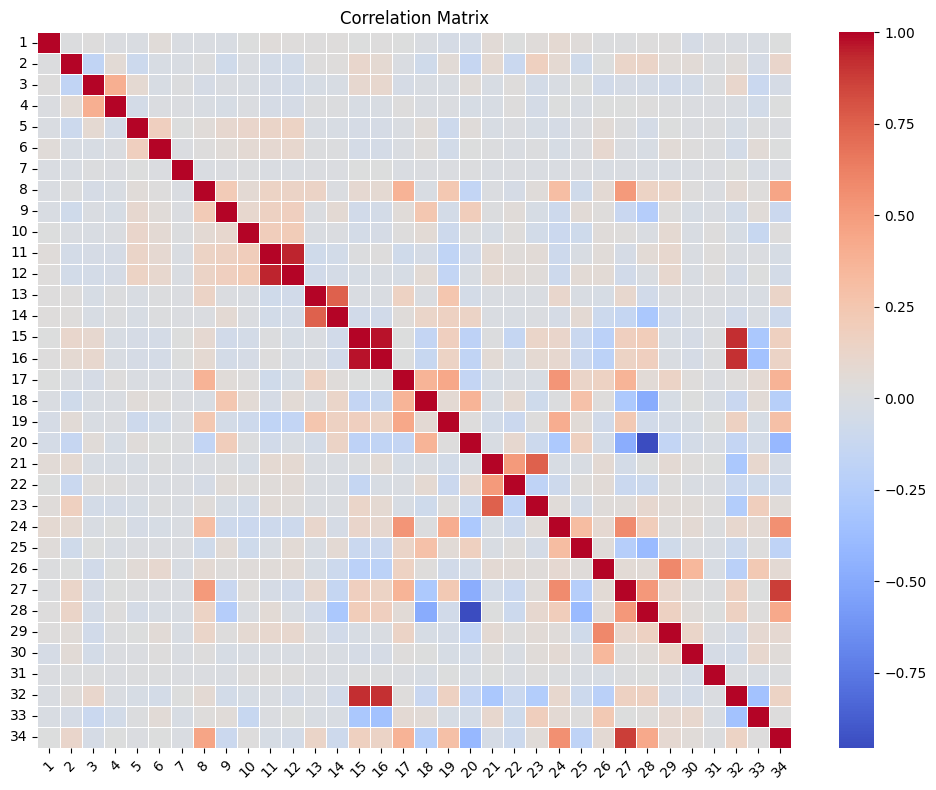

In [7]:
# 3) Perform EDA and calculate the statistics of the dataset: mean, std, correlations among features, etc.
#    (e.g.There are 34 features and you have to find the correlations among each feature (34 by 34 correlation matrix)).

selected_columns = [str(i) for i in range(1, 35)]

# statistics
means = df[selected_columns].mean()
stds = df[selected_columns].std()

print("\nStatistics:")
for column, mean, std in zip(selected_columns, means, stds):
    print(f"Column {column}: Mean = {mean:.2f}, Std = {std:.2f}")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)

# correlation matrix
correlation_matrix = df[selected_columns].corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig('correlation_matrix.png')
plt.show()

In [8]:
# 4) Explain the key insight from your observation above.
# 11, 12 / 15, 16, 32 / 27, 34 have correlation higher than 0.8, one feature can be used to represent others

# 5) Perform feature engineering/selection/importance (you may remove no more than 5 features).
#    You can employ any well-known feature engineering methods (PCA, clustering, etc.).
#    Justify your choices and processes.

remove_columns = ['12', '16', '32', '34']
df = df.drop(columns=remove_columns)
print(df.head())

# IF PCA
# pca = PCA(n_components=30)
# data = df[selected_columns]
# pca.fit(data)
# transformed_data = pca.transform(data)

# print("Original shape:", data.shape)
# print("Transformed shape:", transformed_data.shape)
# print(transformed_data)

     1         2         3         4         5         6         7         8  \
0  0.0  0.531646  0.094526  0.013342  0.010483  0.099884  0.009769  0.004464   
1  0.0  0.531646  0.078554  0.013853  0.011625  0.094059  0.009896  0.003571   
2  0.0  0.531646  0.117207  0.018819  0.010483  0.099884  0.009769  0.003571   
3  0.0  0.531646  0.109726  0.014767  0.010309  0.074257  0.009769  0.003571   
4  0.0  0.531646  0.103491  0.012546  0.010748  0.099010  0.009708  0.003571   

       9        10        11        13        14        15        17  \
0  0.006  0.087825  0.102581  0.002535  0.005825  0.513201  0.039955   
1  0.004  0.087825  0.102581  0.002535  0.005437  0.523102  0.039955   
2  0.004  0.087825  0.102581  0.002535  0.005437  0.523102  0.039955   
3  0.004  0.087825  0.102581  0.002535  0.005437  0.523102  0.039955   
4  0.004  0.087825  0.102581  0.002535  0.005437  0.523102  0.039955   

         18        19     20        21        22        23        24     25  \
0  0.05

# Model Selection



# Model Tuning



# Model Evaluation / Metrics